In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import random

from frechetdist import frdist
from find_transform import estimate_transform_params, transform_line, estimate_mean_squared_transformation_error

from utils import build_fragment_from_directory, Fragment, rotate_fragment, pad_fragment_to_size
from utils import shift_fragment, blend_fragments, transform_fragment

from shape_align import align_two_fragments, pairwise_alignment
from find_transform import find_best_transform_ransac, aligned_coords2line

from shape_utils import get_colorized_edge
from shape_utils import linearize_edge
from curvature import edge_coords2curvatures
from shape_align import water
from typing import List, Dict, Tuple
from joblib import Parallel, delayed
from skimage.color import rgb2lab, lab2rgb
from tqdm import tqdm


In [3]:
data_dir = '../dataset'
palette = np.array([[4.83058360e+01, -4.28336049e+00, -1.04226657e+00],
                    [7.28763389e+01,  1.10190913e+01,  2.91083397e+01],
                    [1.93975643e+01,  8.21757008e+00, -6.52862709e+00],
                    [6.12470461e+01,  6.38868771e+00,  1.05191202e+01],
                    [8.70237508e+01,  2.60029629e+00,  6.34060233e+00],
                    [3.84328672e+01,  2.22768163e+01,  1.17465682e+00],
                    [3.29131583e+01,  3.06846260e-02, -6.19825618e+00]])

In [4]:
# def pad_fragment(frag, size):
#     h, w = frag.mask.shape[0], frag.mask.shape[1]
#     pad_h, pad_w = (3 * size - h) // 2, (3 * size - w) // 2
#     return Fragment(
#         np.pad(frag.fragment, ((pad_h, pad_h + 1 * (h % 2 != size % 2)), (pad_w, pad_w + 1 * (w % 2 != size % 2)), (0, 0))),
#         np.pad(frag.extended_frag, ((pad_h, pad_h + 1 * (h % 2 != size % 2)), (pad_w, pad_w + 1 * (w % 2 != size % 2)), (0, 0))),
#         np.pad(frag.mask, ((pad_h, pad_h + 1 * (h % 2 != size % 2)), (pad_w, pad_w + 1 * (w % 2 != size % 2)), (0, 0))),
#         np.pad(frag.extended_mask, ((pad_h, pad_h + 1 * (h % 2 != size % 2)), (pad_w, pad_w + 1 * (w % 2 != size % 2)), (0, 0))),
#     )

# def rotate_fragment(frag, angle):
#     return Fragment(
#         skimage.transform.rotate(frag.fragment, angle),
#         skimage.transform.rotate(frag.extended_frag, angle),
#         skimage.transform.rotate(frag.mask, angle),
#         skimage.transform.rotate(frag.extended_mask, angle),
#     )

In [18]:
frag1 = pad_fragment_to_size(build_fragment_from_directory(data_dir + '/9'), 200)
frag2 = pad_fragment_to_size(build_fragment_from_directory(data_dir + '/11'), 200)

In [19]:
frags = [
    build_fragment_from_directory(data_dir + '/9'),
    build_fragment_from_directory(data_dir + '/11') 
#     build_fragment(14, None), 
#     build_fragment(15, None),
#     build_fragment(10, None),
]

In [20]:
frag3 = rotate_fragment(pad_fragment_to_size(frag1, 200), 60)

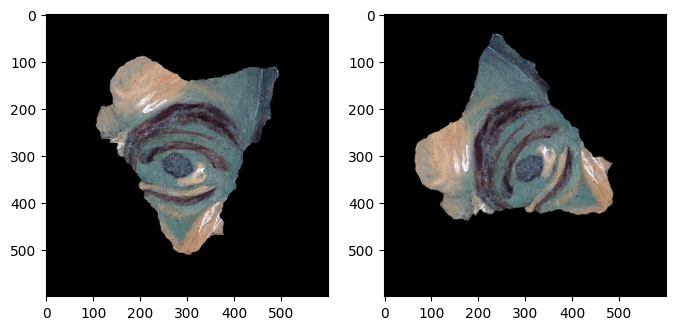

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6))
axes[0].imshow(frag1.fragment)
axes[1].imshow(frag3.fragment)

In [22]:
descriptors, alignment = pairwise_alignment(palette,[frag1, frag2])

Computing shape descriptors...
Computing pairwise alignments...
Aligning fragments 0 and 1:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2516/2516 [00:11<00:00, 214.79it/s]


In [23]:
frags = [frag1, frag2]

In [24]:
l, r = 0, 1

In [25]:
def find_best_fragment_transform(palette, frag1, frag2):
    frags = [frag1, frag2]
    descriptors, alignment = pairwise_alignment(palette, frags)
    line1 = aligned_coords2line(alignment[l], descriptors[l].edge_coords)
    line2 = aligned_coords2line(alignment[r], descriptors[r].edge_coords)
    best_transform = find_best_transform_ransac(line1, line2)
    return best_transform

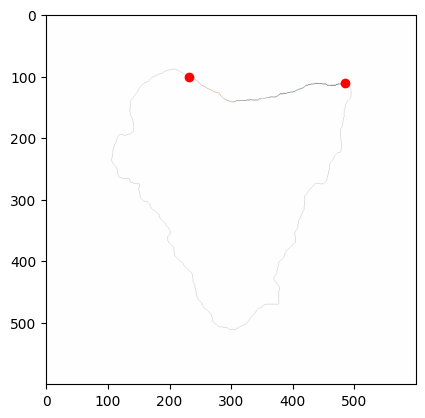

In [26]:
common_edge = np.ones(frags[l].fragment.shape)
color_edge, edge_coords, curvs = descriptors[l].color_edge, descriptors[l].edge_coords, descriptors[l].curvatures
indices = alignment[(l, r)]
i_indices = [i for (i, j) in indices]
for i, point in enumerate(edge_coords):
    common_edge[point[0], point[1]] = 0.8
common_edge = rgb2lab(common_edge)
    
line1 = []
colors = []
for (i, j) in indices:
    color = color_edge[i - 1]
    y, x = edge_coords[i - 1]
    line1.append((y, x))
    colors.append(color)
    
    
for c, (y, x) in zip(colors, line1):
    common_edge[y, x] = c
#     common_edge[y, x] = color

plt.imshow(lab2rgb(common_edge))
common_edge = lab2rgb(common_edge)
y1, x1 = edge_coords[indices[0][0] - 1]
y2, x2 = edge_coords[indices[-1][0] - 1]
plt.scatter([x1, x2], [y1, y2], color='r')
plt.imshow(common_edge)

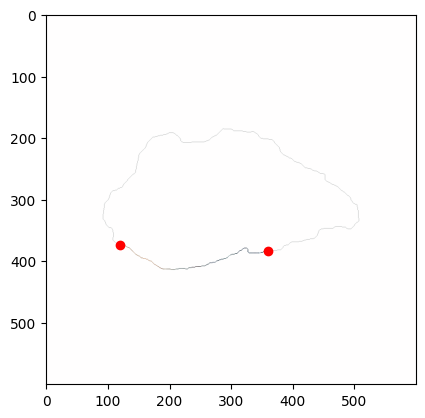

In [27]:
common_edge = np.ones(frags[r].fragment.shape)
color_edge, edge_coords, curvs = descriptors[r].color_edge[::-1], descriptors[r].edge_coords[::-1], descriptors[r].curvatures[::-1]
indices = alignment[(l, r)]
i_indices = [j for (i, j) in indices]
for i, point in enumerate(edge_coords):
    common_edge[point[0], point[1]] = 0.8
common_edge = rgb2lab(common_edge)
    
line2 = []
colors = []
for (i, j) in indices:
    color = color_edge[j - 1]
    y, x = edge_coords[j - 1]
    line2.append((y, x))
    colors.append(color)
    
for c, (y, x) in zip(colors, line2):
    common_edge[y, x] = c
#     common_edge[y, x] = color

plt.imshow(lab2rgb(common_edge))
common_edge = lab2rgb(common_edge)
y1, x1 = edge_coords[indices[0][1] - 1]
y2, x2 = edge_coords[indices[-1][1] - 1]
plt.scatter([x1, x2], [y1, y2], color='r')
plt.imshow(common_edge)

In [28]:
# def descriptor2line(alignment, edge_coords, left=True):
#     indices = alignment[(l, r)]
#     indices = [i if left else j for (i, j) in indices]

#     line = []
#     for k in indices:
#         line.append(edge_coords[k - 1])
#     return np.array(line)

In [29]:
# line1 = np.array(line1)
# line2 = np.array(line2)

In [30]:
alignment

{(0, 1): [(1678, 1404),
  (1677, 1403),
  (1676, 1402),
  (1675, 1401),
  (1674, 1400),
  (1673, 1399),
  (1672, 1398),
  (1671, 1397),
  (1670, 1396),
  (1669, 1395),
  (1668, 1394),
  (1667, 1393),
  (1666, 1392),
  (1665, 1391),
  (1664, 1390),
  (1663, 1389),
  (1662, 1388),
  (1661, 1387),
  (1660, 1386),
  (1659, 1385),
  (1658, 1384),
  (1657, 1383),
  (1656, 1382),
  (1655, 1381),
  (1654, 1380),
  (1653, 1379),
  (1652, 1378),
  (1651, 1377),
  (1650, 1376),
  (1649, 1375),
  (1648, 1374),
  (1647, 1373),
  (1646, 1372),
  (1645, 1371),
  (1644, 1370),
  (1643, 1369),
  (1642, 1368),
  (1641, 1367),
  (1640, 1366),
  (1639, 1365),
  (1638, 1364),
  (1637, 1363),
  (1636, 1362),
  (1635, 1361),
  (1634, 1360),
  (1633, 1359),
  (1632, 1358),
  (1631, 1357),
  (1630, 1356),
  (1629, 1355),
  (1628, 1354),
  (1627, 1353),
  (1626, 1352),
  (1625, 1351),
  (1624, 1350),
  (1623, 1349),
  (1622, 1348),
  (1621, 1347),
  (1620, 1346),
  (1619, 1345),
  (1618, 1344),
  (1617, 1343),


In [31]:
line1 = aligned_coords2line(alignment[(l, r)], descriptors[l].edge_coords, left=True)
line2 = aligned_coords2line(alignment[(l, r)], descriptors[r].edge_coords[::-1], left=False)

In [32]:
# print(estimate_transform_params(line1[0], line1[-1], line2[0], line2[-1]))

In [33]:
line1 -= frags[l].fragment.shape[0] // 2
line2 -= frags[r].fragment.shape[0] // 2

In [34]:
transform_params = estimate_transform_params(line1[0], line1[-1], line2[0], line2[-1])
transformed_line1 = transform_line(line1, transform_params).astype(int)

In [35]:
# def find_best_transform_ransac(line1, line2):
#     length = min(line1.shape[0], line2.shape[0])
#     min_error = 10000
#     best_transform = None
    
#     for i in range(300):
#         l, r = random.choice(range(length)), random.choice(range(length))
#         if l == r: 
#             continue
#         try: 
#             dist = np.linalg.norm(line1[l] - line1[r])
#             distances = np.abs(np.linalg.norm(line2 - line2[l], axis=1) - dist)
#             best_point = np.argmin(distances)
            
#             transform_params = estimate_transform_params(line1[l], line1[r], line2[l], line2[best_point])
#         except Exception as e:
# #             raise e
#             continue
#         error = estimate_mean_squared_transformation_error(line1, line2, transform_params)
        
#         if error < min_error:
#             min_error = error
#             best_transform = transform_params
#     return best_transform

In [36]:
best_transform_params = find_best_transform_ransac(line1, line2)
transformed_line1 = transform_line(line1, best_transform_params).astype(int)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


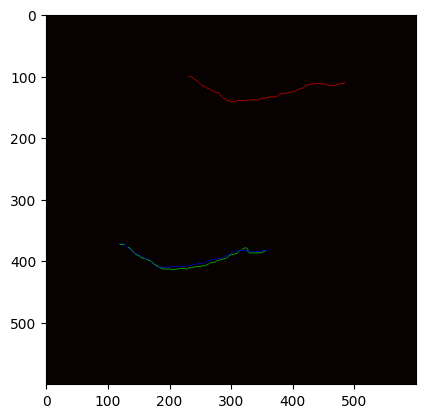

In [37]:
common_edge = np.ones(frags[l].fragment.shape)
# color_edge, edge_coords, curvs = descriptors[l].color_edge, descriptors[l].edge_coords, descriptors[l].curvatures
indices = alignment[(l, r)]
# i_indices = [i for (i, j) in indices]
# for i, point in enumerate(edge_coords):
#     common_edge[point[0], point[1]] = 0.8
# common_edge = rgb2lab(common_edge)
    
# line1 = []
# colors = []
# for (i, j) in indices:
#     color = color_edge[i - 1]
#     y, x = edge_coords[i - 1]
#     line1.append((y, x))
#     colors.append(color)
    
    
# for c, (y, x) in zip(colors, line1):
#     common_edge[y, x] = c
# #     common_edge[y, x] = color

    
# plt.imshow(lab2rgb(common_edge))
common_edge = lab2rgb(common_edge)
line1 += frags[l].fragment.shape[0] // 2
line2 += frags[l].fragment.shape[0] // 2
transformed_line1 += frags[l].fragment.shape[0] // 2
for (y, x) in line1:
    if y < 0 or y >= common_edge.shape[0] or x < 0 or x >= common_edge.shape[1]:
        continue
    common_edge[y, x] = [200, 0, 0]
for (y, x) in line2:
    if y < 0 or y >= common_edge.shape[0] or x < 0 or x >= common_edge.shape[1]:
        continue
    common_edge[y, x] = [0, 200, 0]
for (y, x) in transformed_line1:
    if y < 0 or y >= common_edge.shape[0] or x < 0 or x >= common_edge.shape[1]:
        continue
    common_edge[y, x] = [0, 0, 200]
# y1, x1 = edge_coords[indices[0][0] - 1]
# y2, x2 = edge_coords[indices[-1][0] - 1]
# plt.scatter([x1, x2], [y1, y2], color='r')
plt.imshow(common_edge)

In [38]:
import time

In [39]:
start_time = time.time()
print(frdist(transformed_line1, line2))
print("Time: ", time.time() - start_time)

5.0
Time:  0.8399250507354736


In [44]:
start_time = time.time()
print(frechet_distance(transformed_line1, line2))
print("Time: ", time.time() - start_time)

5.0
Time:  1.6816375255584717


In [45]:
start_time = time.time()
max_dist = 0
dists = [euclidean_distance(transformed_line1[i], line2[i]) for i in range(len(transformed_line1))]
print(max(dists))
print("Time: ", time.time() - start_time)

7.21
Time:  0.007184028625488281


In [42]:
# from .geometry import euclidean_distance
def euclidean_distance(point1, point2):
    '''
    Args:
    point1: type array two values [x, y]
    point2: type array two values [x, y]
    Returns:
    Distance of two points
    Descriptions:
    Calculate Euclidian distance of two points in Euclidian space
    '''
    
    return np.round(np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2), 2)

'''
Discrete Frechet distance between 2 curves
based on http://www.kr.tuwien.ac.at/staff/eiter/et-archive/cdtr9464.pdf
modified to be iterative and have better memory usage
'''

def frechet_distance(curve1, curve2):
    '''
    Args:
    polyP: polynomial representing curve 1
    polyQ: polynomial representing curve 2
    Returns:
    Frechet distance between two curves
    Descriptions:
    Calculate Frechet distance between two curves
    '''
  
    longcalcurve = curve1 if len(curve1) >= len(curve2) else curve2
    shortcalcurve = curve2 if len(curve1) >= len(curve2) else curve1
    
    prev_resultscalcol = []
    for i in range(0, len(longcalcurve)):
        current_resultscalcol = []
        for j in range(0, len(shortcalcurve)):
            current_resultscalcol.append(
                calc_value(
                    i, j, prev_resultscalcol, 
                    current_resultscalcol, 
                    longcalcurve, shortcalcurve
                )
            )
        prev_resultscalcol = current_resultscalcol
    return prev_resultscalcol[len(shortcalcurve) - 1]

def calc_value(i, j, prevResultsCol, currentResultsCol, longCurve, shortCurve):
    if i == 0 and j == 0:
        return euclidean_distance(longCurve[0], shortCurve[0])
    if i > 0 and j == 0:
        return max(prevResultsCol[0], euclidean_distance(longCurve[i], shortCurve[0]))
    last_result = currentResultsCol[len(currentResultsCol) - 1]
    if i == 0 and j > 0:
        return max(last_result, euclidean_distance(longCurve[0], shortCurve[j]))
    return max(
        min(prevResultsCol[j], prevResultsCol[j - 1], last_result),
        euclidean_distance(longCurve[i], shortCurve[j])
    )

In [43]:
best_transform_params

array([ 9.54605480e-01,  1.65070981e-03,  2.62764609e+02, -1.13473259e+02])

In [119]:
np.sqrt(3) / 2

0.8660254037844386

In [131]:
# def shift_fragment(frag, shift_x, shift_y):
#     return Fragment(
#         np.roll(frag.fragment, (shift_y, shift_x), axis=(0, 1)),
#         np.roll(frag.extended_frag, (shift_y, shift_x), axis=(0, 1)),
#         np.roll(frag.mask, (shift_y, shift_x), axis=(0, 1)),
#         np.roll(frag.extended_mask, (shift_y, shift_x), axis=(0, 1))

#     )

In [132]:
# def transform_fragment(fragment, transform_params):
#     cos, sin, a, b = transform_params
#     fragment = rotate_fragment(fragment, -np.rad2deg(np.arccos(cos)))
#     fragment = shift_fragment(fragment, int(b), int(a))
#     return fragment

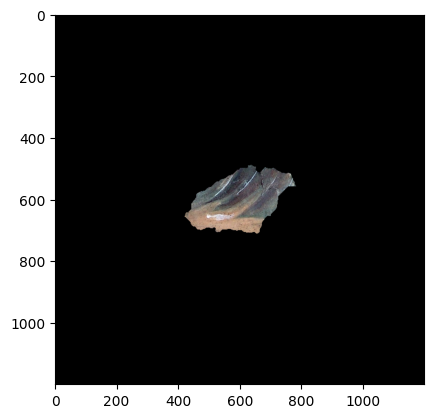

In [133]:
plt.imshow(pad_fragment(frag2, 400).fragment)

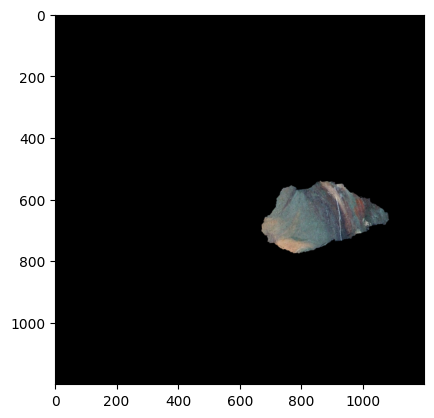

In [134]:
frag4 = transform_fragment(pad_fragment(frag3, 400), best_transform_params)
plt.imshow(frag4.fragment)

In [135]:
# def blend_fragments(frag1, frag2):
#     return Fragment(
#         (frag1.fragment * 1.0 + frag2.fragment * 1.0) / 2,
#         (frag1.extended_frag * 1.0 + frag2.extended_frag * 1.0) / 2,
#         (frag1.mask * 1.0 + frag2.mask * 1.0) / 2,
#         (frag1.extended_mask * 1.0 + frag2.extended_mask * 1.0) / 2,
        
#     )

In [46]:
def find_best_fragment_transform(palette, frag1, frag2):
    frags = [frag1, frag2]
    descriptors, alignment = pairwise_alignment(palette, frags)
    line1 = aligned_coords2line(alignment[(0, 1)], descriptors[0].edge_coords, left=True)
    line2 = aligned_coords2line(alignment[(0, 1)], descriptors[1].edge_coords[::-1], left=False)
    line1 -= frag1.fragment.shape[0] // 2
    line2 -= frag2.fragment.shape[0] // 2
    best_transform = find_best_transform_ransac(line1, line2)
    return best_transform

In [47]:
best_transform_params = find_best_fragment_transform(
    palette, 
    frag1,
    frag2
)

Computing shape descriptors...
Computing pairwise alignments...
Aligning fragments 0 and 1:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2516/2516 [00:11<00:00, 228.48it/s]


In [48]:
best_transform_params

array([ 9.41537527e-01,  2.37010027e-03,  2.61386691e+02, -1.13794956e+02])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


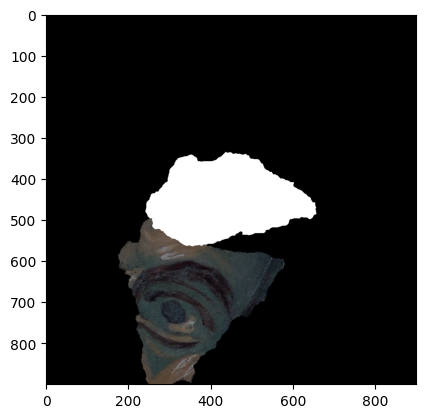

In [53]:
blended = blend_fragments(
    pad_fragment_to_size(frag2, 300),
    transform_fragment(
        pad_fragment_to_size(frag1, 300),
        best_transform_params
    )
)
plt.imshow(blended.fragment)